In [1]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose, LeakyReLU, Dropout, Flatten, AveragePooling2D, AveragePooling3D, UpSampling2D, UpSampling3D
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cmx
import imageio, glob
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA 

2021-08-11 11:25:36.318743: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
npzfile1 = np.load('/gpfs/alpine/gen150/scratch/arjun2612/ORNL_Coding/Code/sars_mers_cov2_dataset/smc2_dataset.npz')
smc2_trainset = npzfile1['train4D']
smc2_valset = npzfile1['val4D']
smc2_lt_onehot = npzfile1['ltoh']
smc2_lv_onehot = npzfile1['lvoh']
smc2_label_validation = npzfile1['labval']

In [3]:
npzfile2 = np.load('/gpfs/alpine/gen150/scratch/arjun2612/ORNL_Coding/Code/hea_dataset/hea_dataset.npz')
hea_trainset = npzfile2['train4D']
hea_valset = npzfile2['val4D']
hea_lt_onehot = npzfile2['ltoh']
hea_lv_onehot = npzfile2['lvoh']
hea_label_validation = npzfile2['labval']

In [4]:
generator = Sequential()

generator.add(Conv2DTranspose(128, (3, 3), padding='same', input_shape=(24, 24, 1), activation=LeakyReLU())) # batch_size x 24 x 24 x 128
generator.add(Conv2DTranspose(64, (3, 3), padding='same', activation=LeakyReLU())) # batch_size x 24 x 24 x 64
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(32, (3, 3), padding='same', activation=LeakyReLU())) # batch_size x 24 x 24 x 64
generator.add(Conv2DTranspose(16, (3, 3), padding='same', activation=LeakyReLU())) # batch_size x 24 x 24 x 64
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(8, (3, 3), padding='same', activation=LeakyReLU())) # batch_size x 24 x 24 x 64
generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, (3, 3), padding='same', activation='tanh')) # batch_size x 24 x 24 x 1

2021-08-11 11:25:38.533490: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-11 11:25:38.534361: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-11 11:25:38.586354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-11 11:25:38.586383: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 11:25:38.588983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-08-11 11:25:38.589061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [5]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 24, 24, 128)       1280      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 64)        73792     
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 24, 24, 16)        4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 24, 24, 8)         1

In [6]:
discriminator = Sequential()
discriminator.add(Conv2D(128, (3, 3), padding='same', input_shape=(24, 24, 1), activation=LeakyReLU()))
discriminator.add(Conv2D(64, (3, 3), padding='same', activation=LeakyReLU()))
discriminator.add(BatchNormalization())

discriminator.add(Conv2D(32, (3, 3), padding='same', activation=LeakyReLU()))
discriminator.add(Conv2D(16, (3, 3), padding='same', activation=LeakyReLU()))
discriminator.add(BatchNormalization())

discriminator.add(Conv2D(8, (3, 3), padding='same', activation=LeakyReLU()))
discriminator.add(Dropout(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='tanh'))
discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [7]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 8)        

In [8]:
gan = Sequential()
discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [9]:
print(gan.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 24, 24, 1)         99745     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 104249    
Total params: 203,994
Trainable params: 99,569
Non-trainable params: 104,425
_________________________________________________________________
None


-0.085465044
Discriminator Decision: Fake


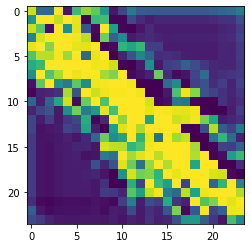

In [34]:
choice = np.random.randint(0, 2)
plt.figure(1)
generated_image = None

if choice == 0:
    noise = tf.random.normal([1, 24, 24, 1])
    generated_image = generator(noise, training=True)

    plt.imshow(generated_image[0, :, :, 0]) # generate some noise to test the generator
elif choice == 1:
    randnum = np.random.randint(0, 60000)
    generated_image = generator(smc2_trainset[randnum:randnum + 1], training=True)
    plt.imshow(generated_image[0, :, :, 0])

decision = discriminator(generated_image, training=False)
decision = decision.numpy()[0][0]
print(decision)

if decision < 0:
    print('Discriminator Decision: Fake') # test out discriminator. Outputs positive values for real and negative values for fake images
elif decision >= 0:
    print('Discriminator Decision: Real') # test out discriminator. Outputs positive values for real and negative values for fake images

In [17]:
def generate_real_samples(dataset, labels, n_samples): # generate real samples with real labels
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = labels[ix]
	return X, y

def generate_fake_samples(n_samples): # generate fake samples with fake labels
    noise = tf.random.normal([n_samples, 24, 24, 1])
    X = generator(noise, training=False)
    y = np.random.uniform(low=-1, high=0, size=n_samples)
    return X, y

In [18]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, model, dataset, d_labels, n_samples):
    X_real, y_real = generate_real_samples(dataset, d_labels, n_samples)
    acc_real = model.evaluate(X_real, y_real)
    
    x_fake, y_fake = generate_fake_samples(n_samples)
    acc_fake = model.evaluate(x_fake, y_fake)

    print('Real Image Accuracy: {}%'.format(acc_real[1] * 100))
    print('Fake Image Accuracy: {}%'.format(acc_fake[1] * 100))

In [19]:
epochs = 10
batch_size = 100

In [20]:
def train(gan_model, dataset, data_labels, n_epochs, n_batch):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, data_labels, half_batch)
            d_loss1 = gan_model.train_on_batch(X_real, y_real)
            d_loss1 = sum(d_loss1) / len(d_loss1)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(half_batch)
            d_loss2 = gan_model.train_on_batch(X_fake, y_fake)
            d_loss2 = sum(d_loss2) / len(d_loss2)
            
            # prepare points in latent space as input for the generator
            X_gan = tf.random.normal([n_batch, 24, 24, 1])
            y_gan = np.random.uniform(low=0, high=1, size=n_batch)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss = sum(g_loss) / len(g_loss)
            # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 2 == 0:
            summarize_performance(i, gan_model, dataset, data_labels, n_batch)

In [21]:
train(gan, smc2_trainset, smc2_lt_onehot, epochs, batch_size)

2021-08-11 10:55:16.182983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-11 10:55:16.204362: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


>1, 600/600, d1=2.904, d2=-3.643 g=3.990
>2, 600/600, d1=2.904, d2=-4.196 g=3.518
4/4 [==============================] - 0s 2ms/step - loss: -8.5700 - accuracy: 0.0000e+00
Real Image Accuracy: 66.66666269302368%
Fake Image Accuracy: 0.0%
>3, 600/600, d1=2.904, d2=-4.001 g=4.016
>4, 600/600, d1=2.904, d2=-4.105 g=3.982
4/4 [==============================] - 0s 2ms/step - loss: -7.9225 - accuracy: 0.0000e+00
Real Image Accuracy: 66.66666269302368%
Fake Image Accuracy: 0.0%
>5, 600/600, d1=2.904, d2=-3.663 g=3.476
>6, 600/600, d1=2.904, d2=-3.791 g=3.345
4/4 [==============================] - 0s 2ms/step - loss: -7.4085 - accuracy: 0.0000e+00
Real Image Accuracy: 66.66666269302368%
Fake Image Accuracy: 0.0%
>7, 600/600, d1=2.904, d2=-4.030 g=3.887
>8, 600/600, d1=2.904, d2=-3.859 g=4.046
4/4 [==============================] - 0s 2ms/step - loss: -7.7030 - accuracy: 0.0000e+00
Real Image Accuracy: 66.66666269302368%
Fake Image Accuracy: 0.0%
>9, 600/600, d1=2.904, d2=-3.958 g=3.509
>10, 60